# Classifying hand written digits from the MNIST database
- Main [source](https://youtu.be/c36lUUr864M?t=10360) that was used for help

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist")

# For notificaiton
import AppKit

In [2]:
# Setting the computing device to be the GPU if possible
# My current laptop doesn't have cuda, but if it would be avalibale
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Since the images are 28x28 pixels in dimentions, the network's input size will
# be 784 as we want it to be a flattened one dimentional array
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 40
batch_size = 64
learning_rate = 0.001


# Getting the MNIST images as tensors by giving the transform function
train_dataset = torchvision.datasets.MNIST(root='./mnistDataset', train=True, transform=transforms.ToTensor(), download=True)

test_dataset  = torchvision.datasets.MNIST(root='./mnistDataset', train=False, transform=transforms.ToTensor(), download=False)


# Seperating the data into batches using the DataLoader utility. Shuffling is good for training, but doesn't matter for evaluation
train_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Making a batch iterator
examples = iter(train_loader)

# Unpacking the training data batches 
samples, labels = examples.next()
print(samples.shape, labels.shape)


torch.Size([64, 1, 28, 28]) torch.Size([64])


Explaining the output `[100, 1, 28, 28]` above 
- 100 = the samples in one batch
- 1   = one color channel - only brightness, no color channels abaliable
- 28  = pixel dimention on first axis
- 28  = pixel dimention on second axis

The second output of `[100]` is simply a vector of labels, to each of the 100 samples in the batch

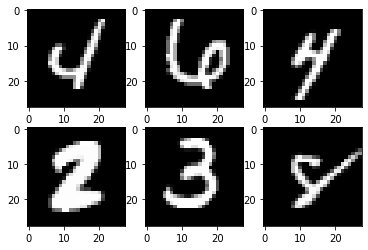

In [3]:
# Plotting some example data
for i in range(6):
    plt.subplot(2,3, i+1)                   # Two rows, by three columns, in the index i+1
    plt.imshow(samples[i][0], cmap='gray')  # Sample i, of the 0 (the first) channel

#plt.show() # This is for plotting, but now we want to add the images to tensorboard
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close() # Flushes outputs
#sys.exit() # Stops execution here

## Making the neural network

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes): # num_classes is the output size
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu   = nn.ReLU() # Activation function
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        # Since this is a multi class classificaiton problem, we're going to use nn.CrossEntropyLoss() below
        # which itself implements Softmax.
        return out

model = NeuralNet(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
# The Adam optimiser is basically a better version of Stochastic Gradient Decent - need more research
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate) #  model.parameters() are the weights

# Wiriting to tensorboard
writer.add_graph(model, samples.reshape(-1, 28*28))
writer.close()

# As we now have the loss and optimiser, we can start doing the training loop

# Training loop

n_total_steps = len(train_loader)
running_loss = 0
running_correct = 0

for epoch in range(num_epochs): # Looping through the epochs
    for i, (images, labels) in enumerate(train_loader): # Looping through the batches
        # The batch in train_loader is currently [100, 1, 28, 28]
        # We want images tensor to be [100, 784], as there are 100 samples and each one have 784 values (28x28 flattened)
        images = images.reshape(-1, 28*28).to(device) # "-1 for first dimention, so tensor can find it out automatically"
        labels = labels.to(device)
        # .to(device) pushes the tensor to the GPU if it's avalaible


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimiser.zero_grad()   # Making sure we're not accumulating the gradients
        loss.backward()         # Calculating the new gradients
        optimiser.step()        # This updates the gradients in the .parameters

        # Add loss to the running loss 
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1) # evaluate along the dimension 1
        running_correct += (predictions == labels).sum().item() # we can call .item() as it's a tensor with one item


        # Printing the loss
        steps_until_print = 50
        if (i+1) % steps_until_print == 0: # This prints every 10 steps
            print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
            # Let's add the mean vlaue to tensorboard
            writer.add_scalar('Training loss', running_loss/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
            # Adding the accuracy
            writer.add_scalar('Accuracy', running_correct/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
            running_loss = 0.0
            running_correct = 0

print("Training is done")
#AppKit.NSBeep()

Epoch 1/40, step 50/157, loss = 0.81294
Epoch 1/40, step 100/157, loss = 0.32256
Epoch 1/40, step 150/157, loss = 0.39478
Epoch 2/40, step 50/157, loss = 0.26534
Epoch 2/40, step 100/157, loss = 0.30062
Epoch 2/40, step 150/157, loss = 0.31517
Epoch 3/40, step 50/157, loss = 0.35888
Epoch 3/40, step 100/157, loss = 0.20985
Epoch 3/40, step 150/157, loss = 0.34576
Epoch 4/40, step 50/157, loss = 0.34063
Epoch 4/40, step 100/157, loss = 0.18805
Epoch 4/40, step 150/157, loss = 0.14642
Epoch 5/40, step 50/157, loss = 0.08368
Epoch 5/40, step 100/157, loss = 0.17167
Epoch 5/40, step 150/157, loss = 0.15094
Epoch 6/40, step 50/157, loss = 0.27920
Epoch 6/40, step 100/157, loss = 0.32909
Epoch 6/40, step 150/157, loss = 0.15429
Epoch 7/40, step 50/157, loss = 0.34909
Epoch 7/40, step 100/157, loss = 0.17230
Epoch 7/40, step 150/157, loss = 0.19512
Epoch 8/40, step 50/157, loss = 0.25660
Epoch 8/40, step 100/157, loss = 0.02877
Epoch 8/40, step 150/157, loss = 0.05032
Epoch 9/40, step 50/157,

In [5]:
# Testing and evaluation

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader: 
        # Data handling is a little simmilar to the beginning of the training loop
        images = images.reshape(-1, 28*28).to(device) # "-1 for first dimension, so tensor can find it out automatically"
        labels = labels.to(device)
        outputs = model(images)

        # torch.max returns a touple of (value, index), though we don't need
        # the values here, only the index, which corresponds to the classes
        _, predictions = torch.max(outputs, 1) # evaluate along the dimension 1
        n_samples += labels.shape[0] # This returns the number of samples in the current batch 
        n_correct += (predictions == labels).sum().item() # this compares the amount of correct predictions and adds them 

    accuracy = 100 * n_correct / n_samples
    print(f"Accuracy = {accuracy}") 

Accuracy = 100.0
